In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

%matplotlib inline
sns.set_theme(style="whitegrid")

In [51]:
def load_and_engineer_data(folder_path, label):
    """
    Lit tous les CSV d'un dossier, les synchronise, crée des features statistiques
    et ajoute l'étiquette (label).
    """
    # 1. Lister tous les fichiers
    all_files = glob.glob(os.path.join(folder_path, "*.csv"))
    
    data_frames = []
    
    for filename in all_files:
        # Lire le CSV
        df = pd.read_csv(filename)
        
        # 2. Raccourcissement et renommage des colonnes
        # Le nouveau nom est basé sur le nom du fichier (ex: AX_vibration)
        base_name = os.path.basename(filename).replace('.csv', '')
        
        # S'assurer que le fichier a au moins deux colonnes
        if df.shape[1] < 2:
            print(f"Attention: {filename} ignoré, trop peu de colonnes.")
            continue
            
        # Renommer la colonne de valeur (la deuxième colonne)
        df.columns = ['date', base_name]
        
        # 3. Conversion date et Indexation
        # Utilisation de 'mixed' pour gérer les formats complexes avec PM/AM
        df['date'] = pd.to_datetime(df['date'], format='mixed') 
        df.set_index('date', inplace=True)
        
        # Gestion des index dupliqués
        df = df[~df.index.duplicated(keep='first')]
        
        data_frames.append(df)
        
    # 4. Fusionner les capteurs sur l'axe temporel
    # Utilisation de concat sur axis=1 (colonnes) suivi d'un resample
    # Resample sur 100ms (100L) et prend la moyenne
    df_merged = pd.concat(data_frames, axis=1).resample('50ms').mean()
    
    # Remplir les petites valeurs manquantes (NaN) dues aux décalages de capteurs
    df_merged = df_merged.interpolate(method='time').dropna()
    
    # --- Feature Engineering : Créer des statistiques sur une fenêtre glissante (1s) ---
    # Ceci est crucial pour l'objectif d'Optimisation
    window_size = '10s'
    for col in df_merged.columns:
        if col != 'target':
            # Moyenne (Niveau d'énergie moyen)
            df_merged[f'{col}_mean'] = df_merged[col].rolling(window=window_size).mean()
            # Écart-type (Variance/Stabilité)
            df_merged[f'{col}_std'] = df_merged[col].rolling(window=window_size).std()

            df_merged[f'{col}_max'] = df_merged[col].rolling(window=window_size).max()

            df_merged[f'{col}_min'] = df_merged[col].rolling(window=window_size).min()

            df_merged[f'{col}_range'] = df_merged[f'{col}_max'] - df_merged[f'{col}_min']

            df_merged[f'{col}_skew'] = df_merged[col].rolling(window=window_size).skew()

            df_merged[f'{col}_kurt'] = df_merged[col].rolling(window=window_size).kurt()
            

    # Supprimer les lignes NaN créées par la fenêtre glissante initiale
    df_merged.dropna(inplace=True)
    
    # Ajouter la cible (Target)
    df_merged['target'] = label
    
    # Supprimer les colonnes brutes originales, nous ne gardons que les statistiques
    cols_to_drop = [col for col in df_merged.columns if not col.endswith(('_mean', '_std', 'target', '_max', '_min', '_range', '_skew', '_kurt'))]
    df_merged.drop(columns=cols_to_drop, inplace=True)
    
    return df_merged

# Chemins des dossiers (ajustés à votre structure)
path_saine = "data_saine/" 
path_translation = "data_translation/"

print("Chargement et Feature Engineering des données saines...")
df_saine = load_and_engineer_data(path_saine, 0) # 0 = Sain

print("Chargement et Feature Engineering des données translation...")
df_fault = load_and_engineer_data(path_translation, 1) # 1 = Défaut

# Concaténation finale
df_final = pd.concat([df_saine, df_fault])

print(f"\nShape final du dataset : {df_final.shape}")
print(f"Nombre de features créées : {df_final.shape[1] - 1}")
df_final.head()

Chargement et Feature Engineering des données saines...
Chargement et Feature Engineering des données translation...

Shape final du dataset : (33472, 57)
Nombre de features créées : 56


,AX_vibration_mean,AX_vibration_std,AX_vibration_max,AX_vibration_min,AX_vibration_range,AX_vibration_skew,AX_vibration_kurt,AY_vibration_mean,AY_vibration_std,AY_vibration_max,...,HALL_switch_skew,HALL_switch_kurt,Sound_sensor_mean,Sound_sensor_std,Sound_sensor_max,Sound_sensor_min,Sound_sensor_range,Sound_sensor_skew,Sound_sensor_kurt,target
date,,,,,,,,,,,,,,,,,,,,,
2025-11-27 17:07:55.850,0.135272,0.369677,0.507571,-0.296881,0.804452,-0.285221,-3.154146,9.931148,0.282475,10.295067,...,0.0,-3.0,3.000000,0.000000,3.000000,3.0,0.000000,0.000000,-3.00000,0
2025-11-27 17:07:55.900,0.144610,0.320830,0.507571,-0.296881,0.804452,-0.416999,-1.040282,9.927318,0.244781,10.295067,...,0.0,-3.0,3.000000,0.000000,3.000000,3.0,0.000000,0.000000,-3.00000,0
2025-11-27 17:07:55.950,0.217872,0.338452,0.584185,-0.296881,0.881066,-0.590836,-0.910793,9.975840,0.249120,10.295067,...,0.0,-3.0,3.166667,0.408249,4.000003,3.0,1.000003,2.449490,6.00000,0
2025-11-27 17:07:56.000,0.201797,0.311877,0.584185,-0.296881,0.881066,-0.381559,-0.657320,9.962615,0.230090,10.295067,...,0.0,-3.0,3.428572,0.786796,5.000000,3.0,2.000000,1.759813,2.36093,0
2025-11-27 17:07:56.050,0.166996,0.305059,0.584185,-0.296881,0.881066,-0.019039,-1.059132,9.947908,0.217046,10.295067,...,0.0,-3.0,3.500001,0.755929,5.000000,3.0,2.000000,1.322871,0.87498,0



--- Évaluation du Modèle ---
Accuracy Score: 0.9609

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96      4643
           1       0.96      0.97      0.96      5399

    accuracy                           0.96     10042
   macro avg       0.96      0.96      0.96     10042
weighted avg       0.96      0.96      0.96     10042



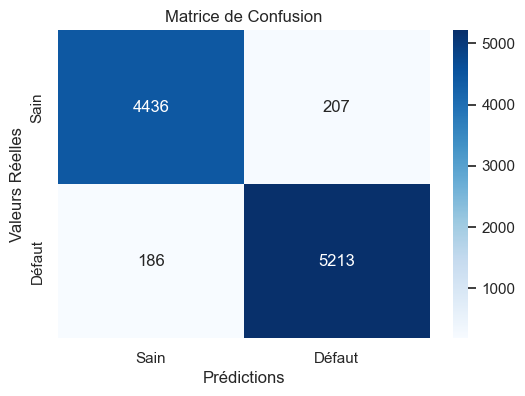

In [71]:
# Séparation Features (X) et Target (y)
X = df_final.drop(['target'], axis=1)
y = df_final['target']

# Division Train / Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) # 30% test

# Standardisation (Mise à l'échelle)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Création et entrainement du modèle de Régression Logistique
model = LogisticRegression(max_iter=10000, class_weight='balanced', penalty='l1', solver='saga')
model.fit(X_train_scaled, y_train)

print("\n--- Évaluation du Modèle ---")

# Prédictions
y_pred = model.predict(X_test_scaled)

# Métriques
print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sain', 'Défaut'], yticklabels=['Sain', 'Défaut'])
plt.xlabel('Prédictions')
plt.ylabel('Valeurs Réelles')
plt.title('Matrice de Confusion')
plt.show()


--- 1. Analyse Visuelle des Distributions des Features Clés ---


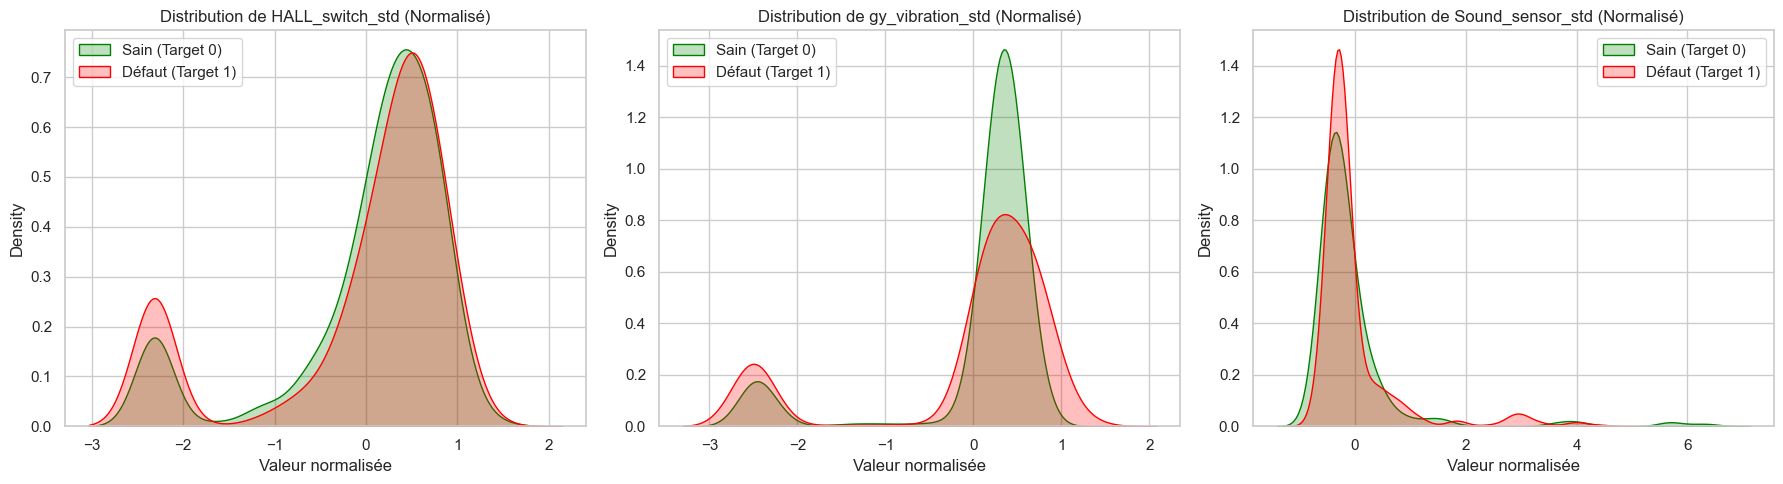


--- 2. Visualisation des Prédictions et Erreurs sur la Série Temporelle ---


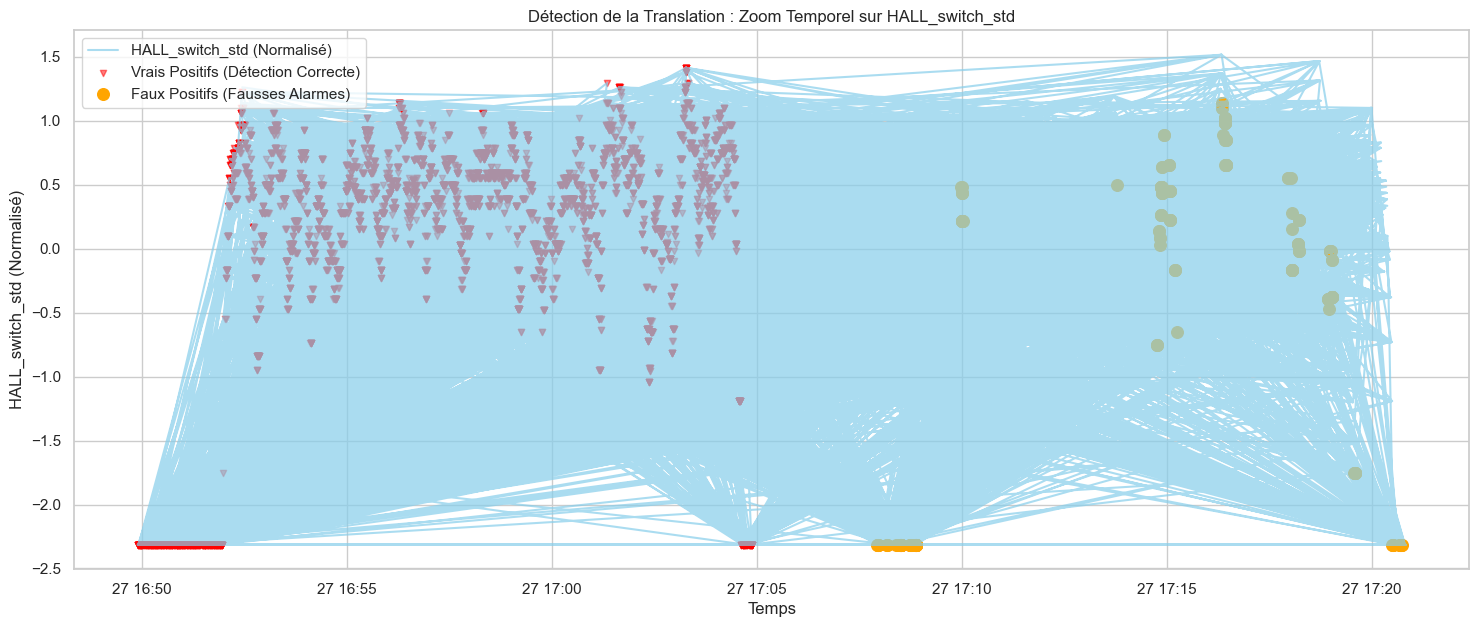


--- 3. Coefficients d'Importance des Features ---


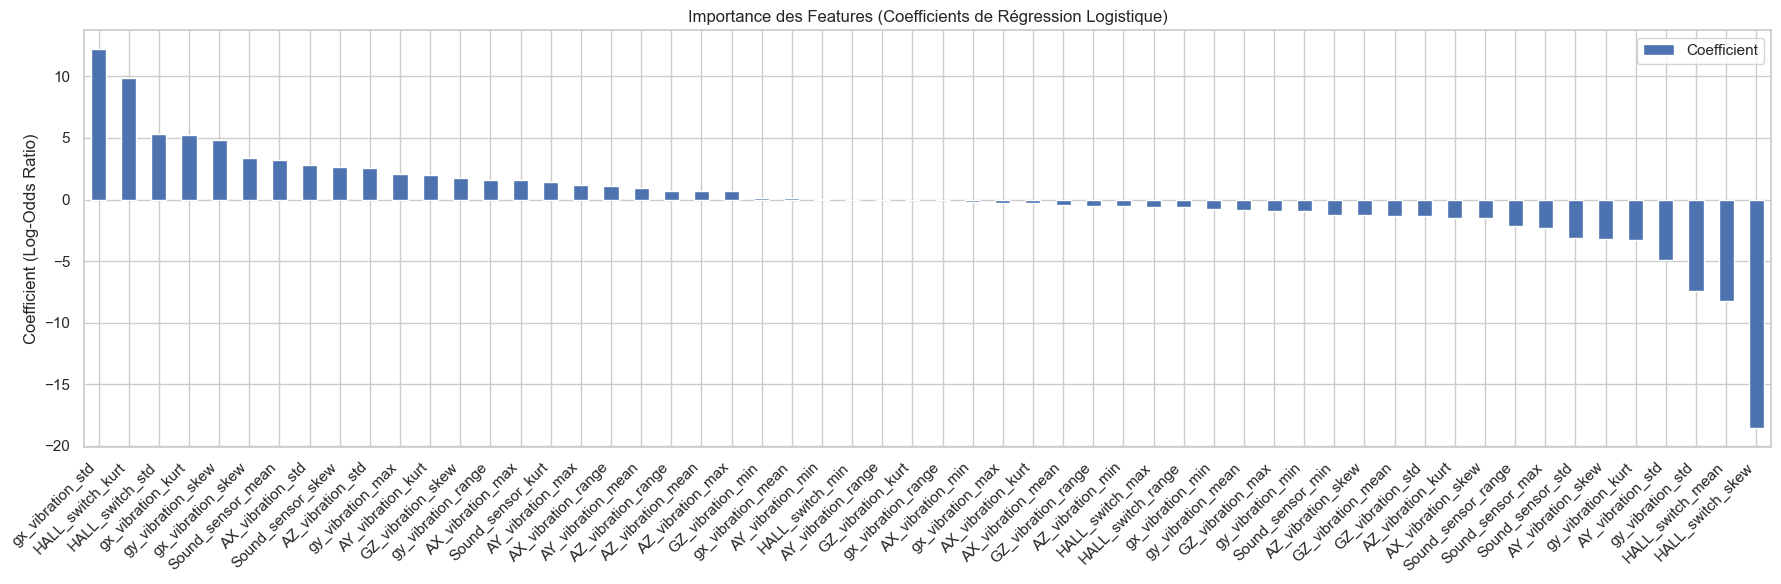

In [72]:
# --- DÉBUT DU BLOC DE VISUALISATION ---

# 1. CRÉER LE DATAFRAME DE TEST POUR LE TRACÉ (SOLUTION DU KEYERROR)
# Utiliser les résultats de la mise à l'échelle (NumPy) mais garantir les noms de colonnes et l'index temporel.
X_test_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
X_test_df['target'] = y_test.values 
X_test_df['prediction'] = y_pred


# --- GRAPHIQUE 1 : Analyse Visuelle des Distributions (Séparation des Classes) ---

print("\n--- 1. Analyse Visuelle des Distributions des Features Clés ---")

# CORRECTION DE LA CASSE : 
# 'GY_vibration_std' doit être remplacé par 'gy_vibration_std' (minuscules)
important_cols = ['HALL_switch_std', 'gy_vibration_std', 'Sound_sensor_std'] 

# Prendre un échantillon pour une meilleure clarté des tracés
sample_df = X_test_df.sample(n=3000, random_state=42) 

plt.figure(figsize=(18, 5))

# Le diagnostic n'est plus nécessaire ici car la liste des colonnes est connue.
# print("Colonnes disponibles dans X_test_df/sample_df:", X_test_df.columns.tolist()) 

for i, col in enumerate(important_cols):
    plt.subplot(1, 3, i + 1)
    
    # Séparer Sain et Défaut pour le tracé
    sain = sample_df[sample_df['target'] == 0]
    defaut = sample_df[sample_df['target'] == 1]
    
    # Tracé des deux distributions
    sns.kdeplot(sain[col], label='Sain (Target 0)', color='green', fill=True)
    sns.kdeplot(defaut[col], label='Défaut (Target 1)', color='red', fill=True)
    
    plt.title(f'Distribution de {col} (Normalisé)')
    plt.xlabel('Valeur normalisée')
    plt.legend()

plt.tight_layout()
plt.show()


# --- GRAPHIQUE 2 : Visualisation des Prédictions sur la Série Temporelle ---

print("\n--- 2. Visualisation des Prédictions et Erreurs sur la Série Temporelle ---")

plot_window = X_test_df.copy()

# Définir le capteur à tracer (le plus important)
sensor_to_plot = 'HALL_switch_std' 

# Isoler une fenêtre de temps pour l'analyse (ex: 4 heures de données)
start_time = plot_window.index.min()
end_time = plot_window.index.min() + pd.Timedelta(hours=4) 
plot_window = plot_window[(plot_window.index >= start_time) & (plot_window.index <= end_time)].copy()

plt.figure(figsize=(18, 7))

# Tracer la feature principale (HALL_switch_std normalisé)
plt.plot(plot_window.index, plot_window[sensor_to_plot], label=f'{sensor_to_plot} (Normalisé)', color='skyblue', alpha=0.7)

# Marquer les Vrais Positifs (VP: Détection Correcte)
vp_points = plot_window[(plot_window['target'] == 1) & (plot_window['prediction'] == 1)]
plt.scatter(vp_points.index, vp_points[sensor_to_plot], color='red', marker='v', s=20, alpha=0.5, label='Vrais Positifs (Détection Correcte)')

# Marquer les Faux Positifs (FP: Fausses Alarmes)
fp_points = plot_window[(plot_window['target'] == 0) & (plot_window['prediction'] == 1)]
plt.scatter(fp_points.index, fp_points[sensor_to_plot], color='orange', marker='o', s=70, label='Faux Positifs (Fausses Alarmes)')

plt.title(f'Détection de la Translation : Zoom Temporel sur {sensor_to_plot}')
plt.xlabel('Temps')
plt.ylabel(f'{sensor_to_plot} (Normalisé)')
plt.legend()
plt.grid(True)
plt.show()

# --- GRAPHIQUE 3 : Coefficients d'Importance (Interprétation) ---
print("\n--- 3. Coefficients d'Importance des Features ---")

# Les coefficients indiquent l'influence de chaque feature sur la probabilité d'une translation
coeffs = pd.DataFrame(model.coef_[0], index=X.columns, columns=['Coefficient'])
coeffs_sorted = coeffs.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(18, 6))
coeffs_sorted.plot(kind='bar', ax=plt.gca())
plt.title("Importance des Features (Coefficients de Régression Logistique)")
plt.ylabel("Coefficient (Log-Odds Ratio)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()